## Implementing Strategy A 

### Differences between Strategy A and Strategy B
See "Strategy B.ipynb" for details, but basically it's this:

"Strategy A" and "Strategy B" have, in common, five scalar parameters required by QLC-2. These are:
- $L$ (crystal dimension)
- $\tau_{eq}$, $\sigma_o$, $\overline N$, and $N^*$ (all atomistic-level characteristics of the ice surface)

In Strategy A, four additional parameters are supplied to QLC-2: 
- $D_{surf}$ (surface diffusion coefficient of the QLL)
- $\nu_{kin}$ (rate at which water vapor strikes the surface)
- $\sigma_{I,corner}$ and $\sigma_{I,middle}$ (water vapor supersaturation above the corner and middle of the crystal)

By contrast, Strategy B's additional parameters are
- $T$ (ambient temperature)
- $P$ (ambient air pressure)
- $\sigma_{I,far}$ and $x_{far}$ (super/subsaturation of water vapor far from the crystal, and distance from the crystal at which $\sigma_{I,far}$ is specified)

### Implementing Strategy A
The code below implements Strategy A, for a range of scenarios.

In [124]:
import numpy as np
import matplotlib.pylab as plt
from pint import UnitRegistry; AssignQuantity = UnitRegistry().Quantity
from importlib import reload
from scipy import optimize

# QLC-specific code
import QLCstuff as QLC; reload(QLC)
from matplotlib import rcParams

In [125]:
%matplotlib inline
ticklabelsize = 15
linewidth = 1
fontsize = 15
color = 'k'
markersize = 10

# Preferred units
distance_unit = 'micrometer'
pressure_unit = 'pascal'
time_unit = 'microsecond'
temperature_unit = 'kelvin'

### Parameterizing
These parameters are based on a Strategy B run using 

    T = 250 K
    P = 30 Pa 
    L = 30 um
    sigmaI(far) = 0.25

For both strategies, we require 

    L, tau, sigma0, Nbar, and Nstar

For Strategy A, we require in addition

    D, nu_kin, sigmaI_corner, c_r

### These are parameters we're not planning on varying

In [126]:
# Properties of the QLL
Nbar = 1.0
Nstar = .9/(2*np.pi)
print('Nbar =', Nbar)
print('Nstar =', Nstar)

# The equilibration time
tau_eq = AssignQuantity(1,'microsecond')
print('tau_eq =',tau_eq)

# Difference in equilibrium supersaturation between microsurfaces I and II
sigma0 = 0.2
print('sigma0 =',sigma0)

# Thickness of a monolayer (have to decide which of these we want)
# nmpermonolayer = AssignQuantity(0.3,'nanometer')
nmpermonolayer = AssignQuantity(0.389,'nanometer') # Prismatic facet as used in Neshyba et al 2016
print('nmpermonolayer =', nmpermonolayer)

# Other baseline values
D_baseline = AssignQuantity(3.65e-04,'micrometer^2/microsecond'); print('D_baseline =',D_baseline)
nu_kin_baseline = AssignQuantity(105,'micrometer/second'); print('nu_kin_baseline =', nu_kin_baseline)
L_baseline = AssignQuantity(30,'micrometer'); print('L_baseline =', L_baseline)

Nbar = 1.0
Nstar = 0.1432394487827058
tau_eq = 1 microsecond
sigma0 = 0.2
nmpermonolayer = 0.389 nanometer
D_baseline = 0.000365 micrometer ** 2 / microsecond
nu_kin_baseline = 105 micrometer / second
L_baseline = 30 micrometer


### Parameters we are planning on varying

In [127]:
# Baseline results from Strategy B
growing = True
ablating = not growing
exploring_sigmaI_corner = True

if growing: # Baseline from Strategy B
    sigmaI_corner_baseline = AssignQuantity(0.244,'dimensionless') 
    c_r_percent_baseline = AssignQuantity(1.068,'dimensionless')
    c_r_baseline = c_r_percent_baseline/100
elif ablating:
    print('Have to fix these baselines')
    sigmaI_corner_baseline = AssignQuantity(-0.044,'dimensionless')
    c_r_percent_baseline = AssignQuantity(5.921,'dimensionless')
    c_r_baseline = c_r_percent_baseline/100
    
print(growing)
print(ablating)
print(exploring_sigmaI_corner)

True
False
True


In [128]:
parameter_names = ['L', 'D', 'nu_kin', 'sigmaI_corner', 'c_r(%)']; print(parameter_names)
result_names = ['g_ice_QLC', 'lambda_average', 'alpha']; print(result_names)

['L', 'D', 'nu_kin', 'sigmaI_corner', 'c_r(%)']
['g_ice_QLC', 'lambda_average', 'alpha']


In [129]:
# Scenarios
if growing and not exploring_sigmaI_corner:

    # Growth baseline (from Strategy B)
    parameterlist_mag = [
    [L_baseline.magnitude, D_baseline.magnitude, nu_kin_baseline.magnitude, 
     sigmaI_corner_baseline.magnitude, c_r_percent_baseline.magnitude],

    # Include these to explore dependence on c_r
    [L_baseline.magnitude, D_baseline.magnitude, nu_kin_baseline.magnitude, sigmaI_corner_baseline.magnitude, 0.10],
    [L_baseline.magnitude, D_baseline.magnitude, nu_kin_baseline.magnitude, sigmaI_corner_baseline.magnitude, 0.20],
    [L_baseline.magnitude, D_baseline.magnitude, nu_kin_baseline.magnitude, sigmaI_corner_baseline.magnitude, 0.25],
    [L_baseline.magnitude, D_baseline.magnitude, nu_kin_baseline.magnitude, sigmaI_corner_baseline.magnitude, 0.50],
    [L_baseline.magnitude, D_baseline.magnitude, nu_kin_baseline.magnitude, sigmaI_corner_baseline.magnitude, 0.75],
    [L_baseline.magnitude, D_baseline.magnitude, nu_kin_baseline.magnitude, sigmaI_corner_baseline.magnitude, 1.25],
    [L_baseline.magnitude, D_baseline.magnitude, nu_kin_baseline.magnitude, sigmaI_corner_baseline.magnitude, 1.50],
#     [L_baseline.magnitude, D_baseline.magnitude, nu_kin_baseline.magnitude, sigmaI_corner_baseline.magnitude, 2.00],

    # Include these to explore dependence on D
    [L_baseline.magnitude, 0.0002, nu_kin_baseline.magnitude, sigmaI_corner_baseline.magnitude, c_r_percent_baseline.magnitude],
    [L_baseline.magnitude, 0.0005, nu_kin_baseline.magnitude, sigmaI_corner_baseline.magnitude, c_r_percent_baseline.magnitude],
    [L_baseline.magnitude, 0.0008, nu_kin_baseline.magnitude, sigmaI_corner_baseline.magnitude, c_r_percent_baseline.magnitude],
    [L_baseline.magnitude, 0.0011, nu_kin_baseline.magnitude, sigmaI_corner_baseline.magnitude, c_r_percent_baseline.magnitude],
    [L_baseline.magnitude, 0.0014, nu_kin_baseline.magnitude, sigmaI_corner_baseline.magnitude, c_r_percent_baseline.magnitude],
    [L_baseline.magnitude, 0.0020, nu_kin_baseline.magnitude, sigmaI_corner_baseline.magnitude, c_r_percent_baseline.magnitude],
    [L_baseline.magnitude, 0.0025, nu_kin_baseline.magnitude, sigmaI_corner_baseline.magnitude, c_r_percent_baseline.magnitude],

    # Include these to explore dependence on nu_kin
#     [L_baseline.magnitude, D_baseline.magnitude, 25, sigmaI_corner_baseline.magnitude, c_r_percent_baseline.magnitude],
    [L_baseline.magnitude, D_baseline.magnitude, 50, sigmaI_corner_baseline.magnitude, c_r_percent_baseline.magnitude],
    [L_baseline.magnitude, D_baseline.magnitude, 75, sigmaI_corner_baseline.magnitude, c_r_percent_baseline.magnitude],
    [L_baseline.magnitude, D_baseline.magnitude,125, sigmaI_corner_baseline.magnitude, c_r_percent_baseline.magnitude],
    [L_baseline.magnitude, D_baseline.magnitude,150, sigmaI_corner_baseline.magnitude, c_r_percent_baseline.magnitude],
#     [L_baseline.magnitude, D_baseline.magnitude,200, sigmaI_corner_baseline.magnitude, c_r_percent_baseline.magnitude],

    # This closes the list 
    ]   

elif ablating and not exploring_sigmaI_corner:

    # Ablation baseline (from Strategy B)
    parameterlist_mag = [
    [L_baseline.magnitude, D_baseline.magnitude, nu_kin_baseline.magnitude, 
     sigmaI_corner_baseline.magnitude, c_r_percent_baseline.magnitude],

    # Include these to explore dependence on c_r
    [L_baseline.magnitude, D_baseline.magnitude, nu_kin_baseline.magnitude, sigmaI_corner_baseline.magnitude, 0.10],
    [L_baseline.magnitude, D_baseline.magnitude, nu_kin_baseline.magnitude, sigmaI_corner_baseline.magnitude, 0.20],
    [L_baseline.magnitude, D_baseline.magnitude, nu_kin_baseline.magnitude, sigmaI_corner_baseline.magnitude, 0.25],
    [L_baseline.magnitude, D_baseline.magnitude, nu_kin_baseline.magnitude, sigmaI_corner_baseline.magnitude, 0.50],
    [L_baseline.magnitude, D_baseline.magnitude, nu_kin_baseline.magnitude, sigmaI_corner_baseline.magnitude, 0.75],
    [L_baseline.magnitude, D_baseline.magnitude, nu_kin_baseline.magnitude, sigmaI_corner_baseline.magnitude, 1.25],
    [L_baseline.magnitude, D_baseline.magnitude, nu_kin_baseline.magnitude, sigmaI_corner_baseline.magnitude, 1.50],
    [L_baseline.magnitude, D_baseline.magnitude, nu_kin_baseline.magnitude, sigmaI_corner_baseline.magnitude, 2.00],

    # Include these to explore dependence on D
    [L_baseline.magnitude, 0.0002, nu_kin_baseline.magnitude, sigmaI_corner_baseline.magnitude, c_r_percent_baseline],
    [L_baseline.magnitude, 0.0005, nu_kin_baseline.magnitude, sigmaI_corner_baseline.magnitude, c_r_percent_baseline],
    [L_baseline.magnitude, 0.0008, nu_kin_baseline.magnitude, sigmaI_corner_baseline.magnitude, c_r_percent_baseline],
    [L_baseline.magnitude, 0.0011, nu_kin_baseline.magnitude, sigmaI_corner_baseline.magnitude, c_r_percent_baseline],
    [L_baseline.magnitude, 0.0014, nu_kin_baseline.magnitude, sigmaI_corner_baseline.magnitude, c_r_percent_baseline],
    [L_baseline.magnitude, 0.0020, nu_kin_baseline.magnitude, sigmaI_corner_baseline.magnitude, c_r_percent_baseline],
    [L_baseline.magnitude, 0.0025, nu_kin_baseline.magnitude, sigmaI_corner_baseline.magnitude, c_r_percent_baseline],

    # Include these to explore dependence on nu_kin
    [L_baseline.magnitude, D_baseline.magnitude, 50, sigmaI_corner_baseline.magnitude, c_r_percent_baseline],
    [L_baseline.magnitude, D_baseline.magnitude, 75, sigmaI_corner_baseline.magnitude, c_r_percent_baseline],
    [L_baseline.magnitude, D_baseline.magnitude,125, sigmaI_corner_baseline.magnitude, c_r_percent_baseline],
    [L_baseline.magnitude, D_baseline.magnitude,150, sigmaI_corner_baseline.magnitude, c_r_percent_baseline],
    [L_baseline.magnitude, D_baseline.magnitude,200, sigmaI_corner_baseline.magnitude, c_r_percent_baseline],

    # This closes the list 
    ]   

elif growing: # exploring_sigmaI_corner greater than sigma0

    # Growth baseline (from Strategy B)
    parameterlist_mag = [
    [L_baseline.magnitude, D_baseline.magnitude, nu_kin_baseline.magnitude, 
     sigmaI_corner_baseline.magnitude, c_r_percent_baseline.magnitude],
        
    # Include these to explore dependence on sigmaI_corner
    [L_baseline.magnitude, D_baseline.magnitude, nu_kin_baseline.magnitude, 0.22, c_r_percent_baseline.magnitude],
    [L_baseline.magnitude, D_baseline.magnitude, nu_kin_baseline.magnitude, 0.23, c_r_percent_baseline.magnitude],
    [L_baseline.magnitude, D_baseline.magnitude, nu_kin_baseline.magnitude, 0.24, c_r_percent_baseline.magnitude],
    [L_baseline.magnitude, D_baseline.magnitude, nu_kin_baseline.magnitude, 0.26, c_r_percent_baseline.magnitude],
    [L_baseline.magnitude, D_baseline.magnitude, nu_kin_baseline.magnitude, 0.28, c_r_percent_baseline.magnitude],
    [L_baseline.magnitude, D_baseline.magnitude, nu_kin_baseline.magnitude, 0.30, c_r_percent_baseline.magnitude],
    [L_baseline.magnitude, D_baseline.magnitude, nu_kin_baseline.magnitude, 0.35, c_r_percent_baseline.magnitude],
    [L_baseline.magnitude, D_baseline.magnitude, nu_kin_baseline.magnitude, 0.40, c_r_percent_baseline.magnitude],

    # This closes the list 
    ]   

elif ablating: # exploring_sigmaI_corner less than 0

    # Growth baseline (from Strategy B)
    parameterlist_mag = [
    [L_baseline.magnitude, D_baseline.magnitude, nu_kin_baseline.magnitude, 
     sigmaI_corner_baseline.magnitude, c_r_percent_baseline.magnitude],
        
    # Include these to explore dependence on sigmaI_corner
    [L_baseline.magnitude, D_baseline.magnitude, nu_kin_baseline.magnitude, -0.002, c_r_percent_baseline.magnitude],
    [L_baseline.magnitude, D_baseline.magnitude, nu_kin_baseline.magnitude, -0.005, c_r_percent_baseline.magnitude],
    [L_baseline.magnitude, D_baseline.magnitude, nu_kin_baseline.magnitude, -0.01, c_r_percent_baseline.magnitude],
    [L_baseline.magnitude, D_baseline.magnitude, nu_kin_baseline.magnitude, -0.02, c_r_percent_baseline.magnitude],
    [L_baseline.magnitude, D_baseline.magnitude, nu_kin_baseline.magnitude, -0.03, c_r_percent_baseline.magnitude],
    [L_baseline.magnitude, D_baseline.magnitude, nu_kin_baseline.magnitude, -0.04, c_r_percent_baseline.magnitude],
    [L_baseline.magnitude, D_baseline.magnitude, nu_kin_baseline.magnitude, -0.06, c_r_percent_baseline.magnitude],
    [L_baseline.magnitude, D_baseline.magnitude, nu_kin_baseline.magnitude, -0.06, c_r_percent_baseline.magnitude],
    [L_baseline.magnitude, D_baseline.magnitude, nu_kin_baseline.magnitude, -0.07, c_r_percent_baseline.magnitude],
    [L_baseline.magnitude, D_baseline.magnitude, nu_kin_baseline.magnitude, -0.08, c_r_percent_baseline.magnitude],
    [L_baseline.magnitude, D_baseline.magnitude, nu_kin_baseline.magnitude, -0.09, c_r_percent_baseline.magnitude],
    [L_baseline.magnitude, D_baseline.magnitude, nu_kin_baseline.magnitude, -0.10, c_r_percent_baseline.magnitude],
    [L_baseline.magnitude, D_baseline.magnitude, nu_kin_baseline.magnitude, -0.11, c_r_percent_baseline.magnitude],

    # This closes the list 
    ]   

else:
    print('Option not implemented')
        

        
print(parameterlist_mag)

[[30, 0.000365, 105, 0.244, 1.068], [30, 0.000365, 105, 0.22, 1.068], [30, 0.000365, 105, 0.23, 1.068], [30, 0.000365, 105, 0.24, 1.068], [30, 0.000365, 105, 0.26, 1.068], [30, 0.000365, 105, 0.28, 1.068], [30, 0.000365, 105, 0.3, 1.068], [30, 0.000365, 105, 0.35, 1.068], [30, 0.000365, 105, 0.4, 1.068]]


L = 30 micrometer
D =  0.000365 micrometer ** 2 / microsecond
nu_kin =  105 micrometer / second
nu_kin_mlyperus = 0.26992287917737784 / microsecond
sigmaI_corner = 0.244 dimensionless
c_r_percent = 1.068 dimensionless
nx (crystal) = 600
Spacing of points on the ice surface = 0.10016694490818168 micrometer
Estimating times for the trajectory run
   time (est) =  286.6910895404979 millisecond
   time (used) =  286.6910895404979 millisecond
   dt = 1930.5797275454406 microsecond
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100% done
c_r(%) = 1.068 dimensionless
final g_ice_QLC = 8.886086713724287 micrometer / second
alpha relative to sigmaI_corner = 0.3468417921047731 dimensionless
nsteps average of last 30.0 % ( 30 points) = 17.908522532349032
estimated lambda = 1.6751800683618399 micrometer
Done with scenario  1  out of  9
--------------------
L = 30 micrometer
D =  0.000365 micrometer ** 2 / microsecond
nu_kin =  105 micrometer / second
nu_k

/Users/nesh/anaconda3/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1335: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100% done
c_r(%) = 1.068 dimensionless
final g_ice_QLC = 5.503433362895489 micrometer / second
alpha relative to sigmaI_corner = 0.23824386852361423 dimensionless
nsteps average of last 30.0 % ( 30 points) = 17.090422591688412
estimated lambda = 1.7553691161849856 micrometer
Done with scenario  2  out of  9
--------------------
L = 30 micrometer
D =  0.000365 micrometer ** 2 / microsecond
nu_kin =  105 micrometer / second
nu_kin_mlyperus = 0.26992287917737784 / microsecond
sigmaI_corner = 0.23 dimensionless
c_r_percent = 1.068 dimensionless
nx (crystal) = 600
Spacing of points on the ice surface = 0.10016694490818168 micrometer
Estimating times for the trajectory run
   time (est) =  286.6910895404979 millisecond
   time (used) =  286.6910895404979 millisecond
   dt = 1930.5797275454406 microsecond
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100% done


/Users/nesh/Documents/Repositories/icecontinuum/nesh/Integrated_QLC_VF/QLCstuff.py:802: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


c_r(%) = 1.068 dimensionless
final g_ice_QLC = 12.988168634732078 micrometer / second
alpha relative to sigmaI_corner = 0.4417744433582339 dimensionless
nsteps average of last 30.0 % ( 30 points) = 20.71411520609111
estimated lambda = 1.4482877835485979 micrometer
Done with scenario  6  out of  9
--------------------
L = 30 micrometer
D =  0.000365 micrometer ** 2 / microsecond
nu_kin =  105 micrometer / second
nu_kin_mlyperus = 0.26992287917737784 / microsecond
sigmaI_corner = 0.3 dimensionless
c_r_percent = 1.068 dimensionless
nx (crystal) = 600
Spacing of points on the ice surface = 0.10016694490818168 micrometer
Estimating times for the trajectory run
   time (est) =  286.6910895404979 millisecond
   time (used) =  286.6910895404979 millisecond
   dt = 1930.5797275454406 microsecond
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100% done
c_r(%) = 1.068 dimensionless
final g_ice_QLC = 15.076131926031179 micrometer / second
alpha relative t

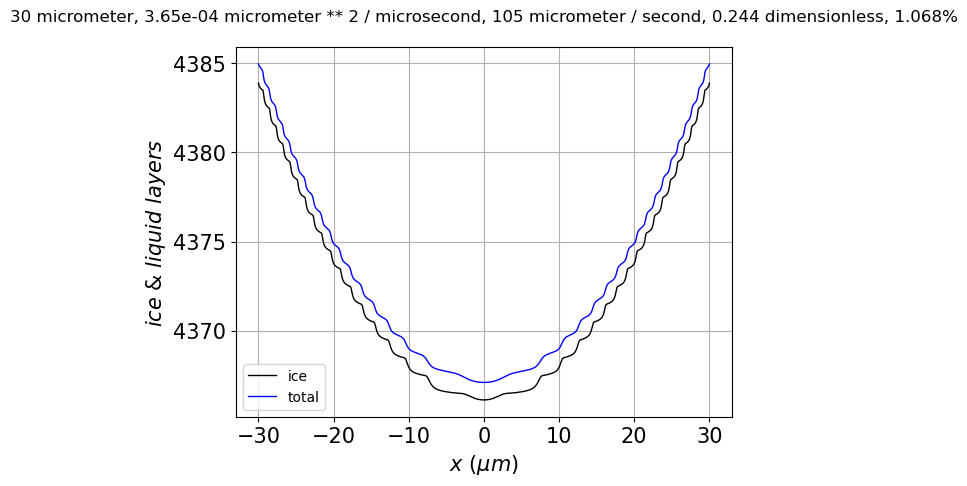

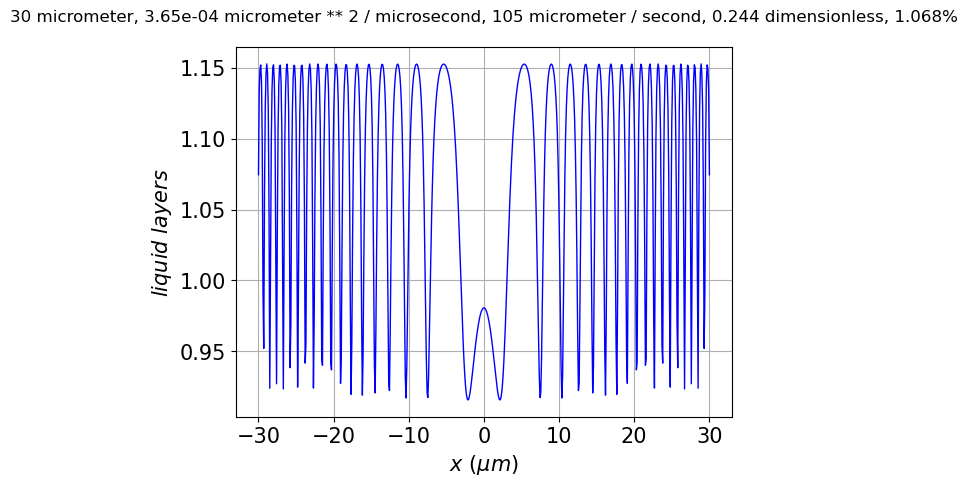

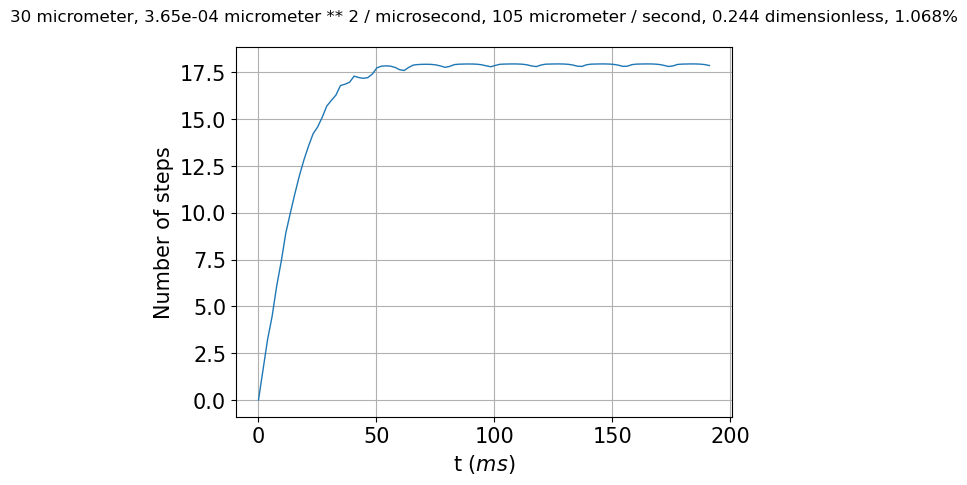

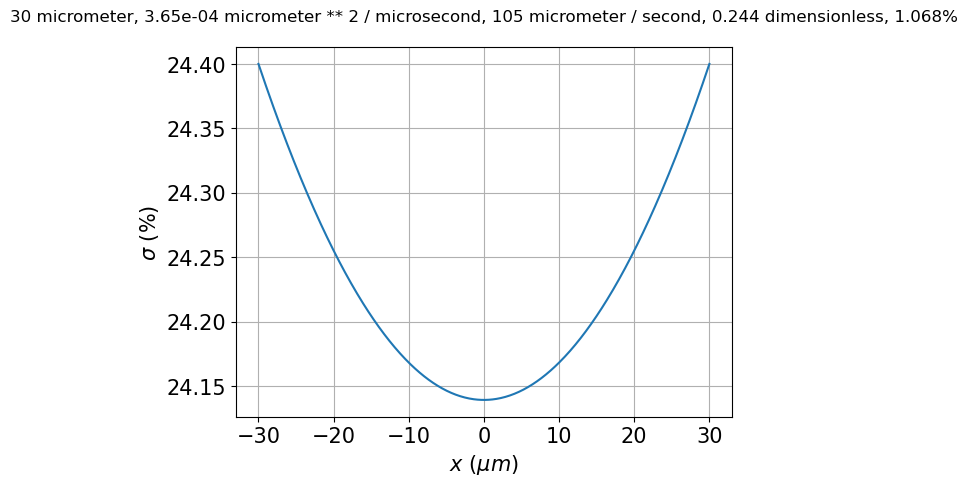

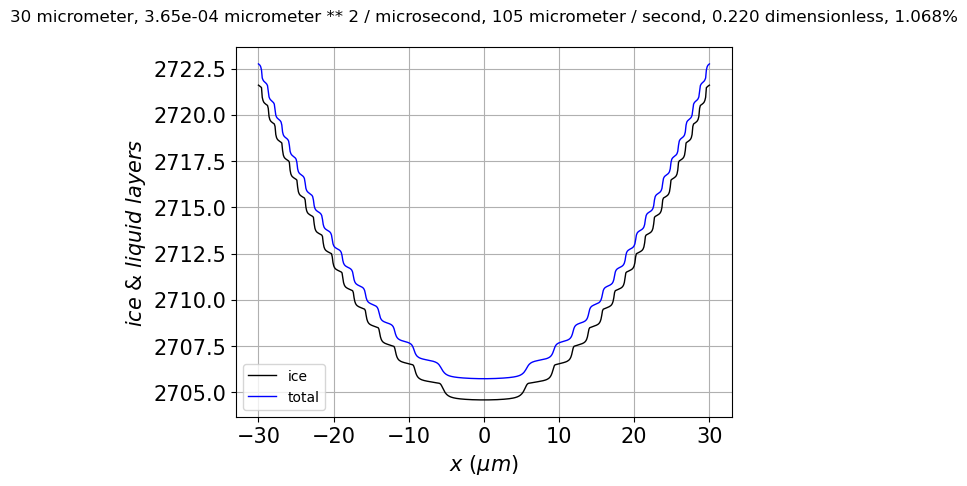

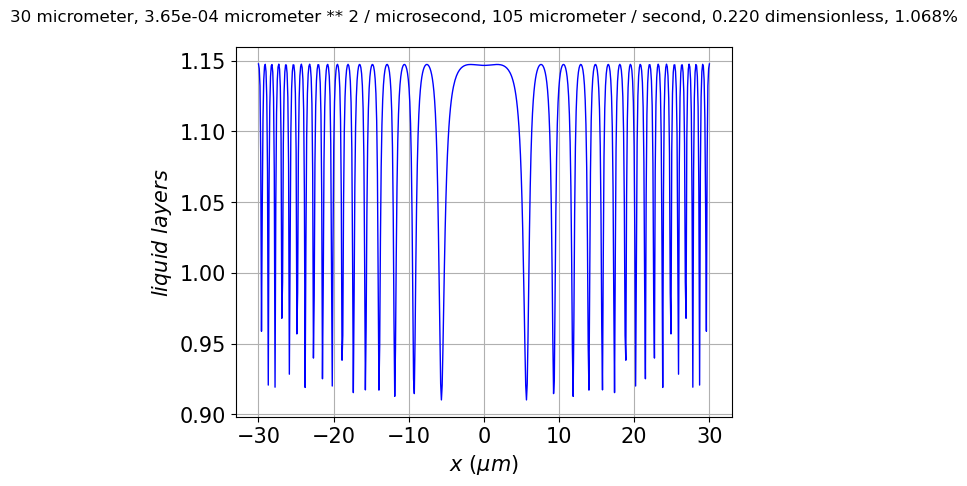

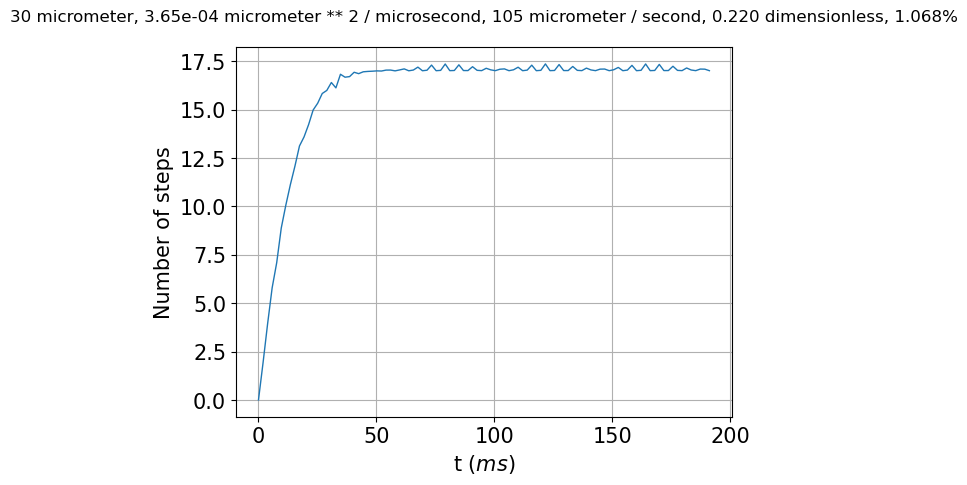

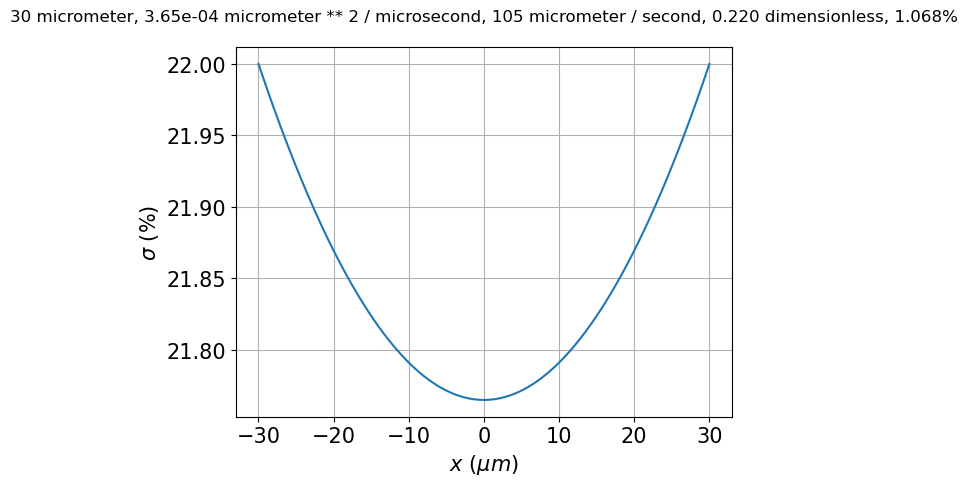

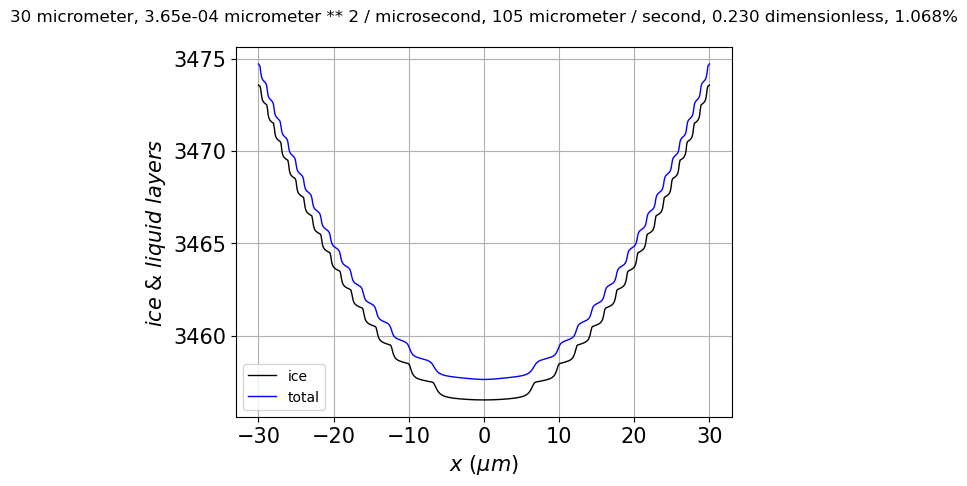

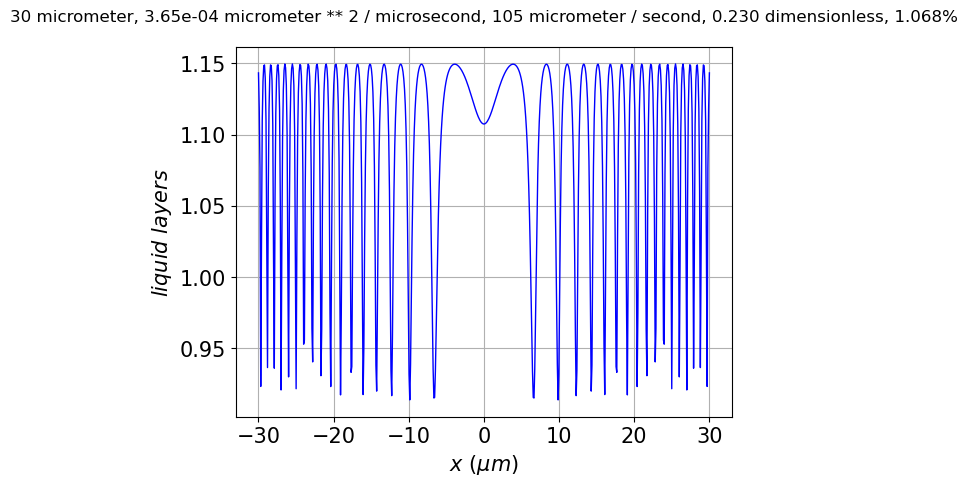

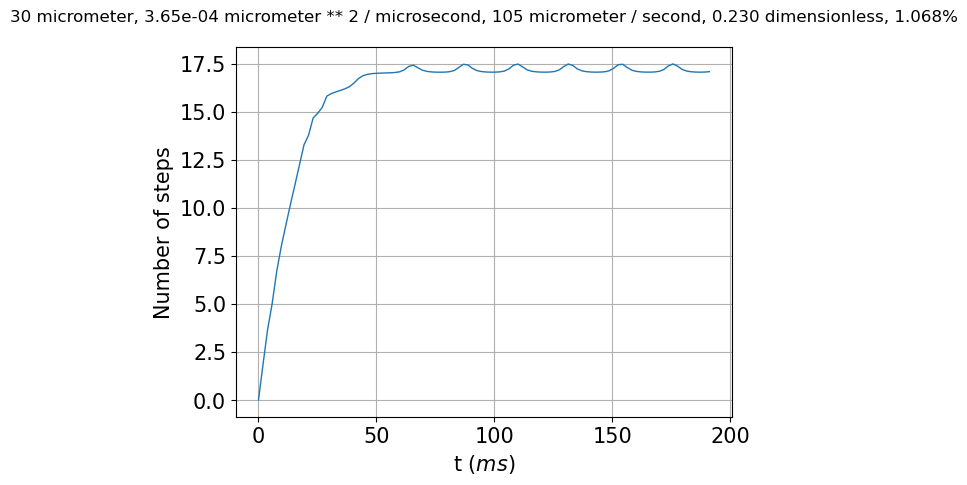

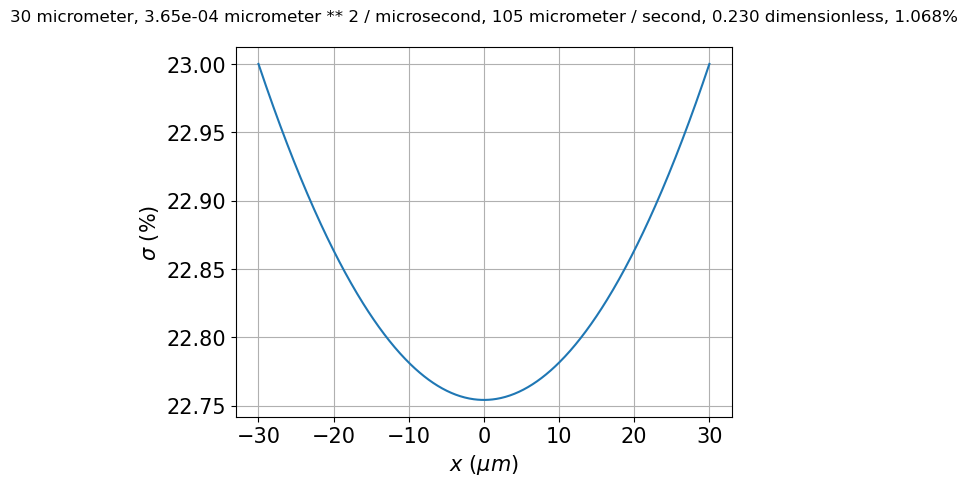

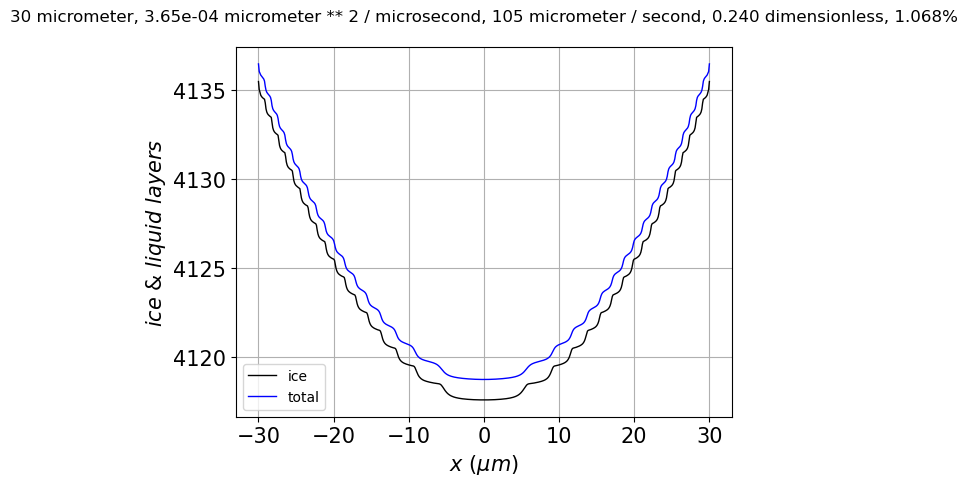

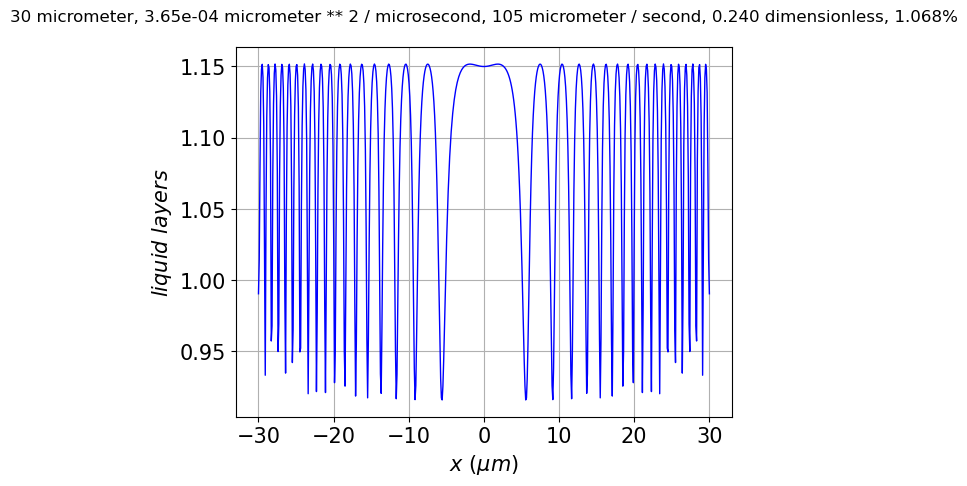

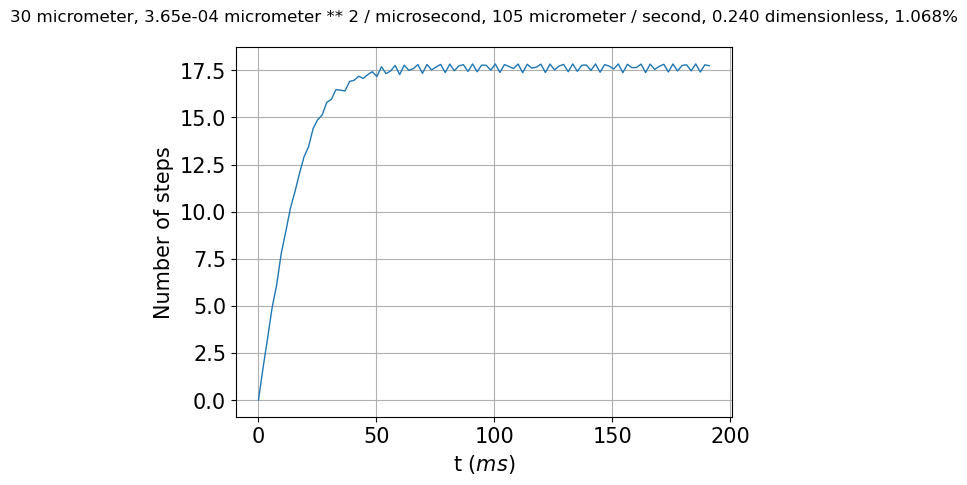

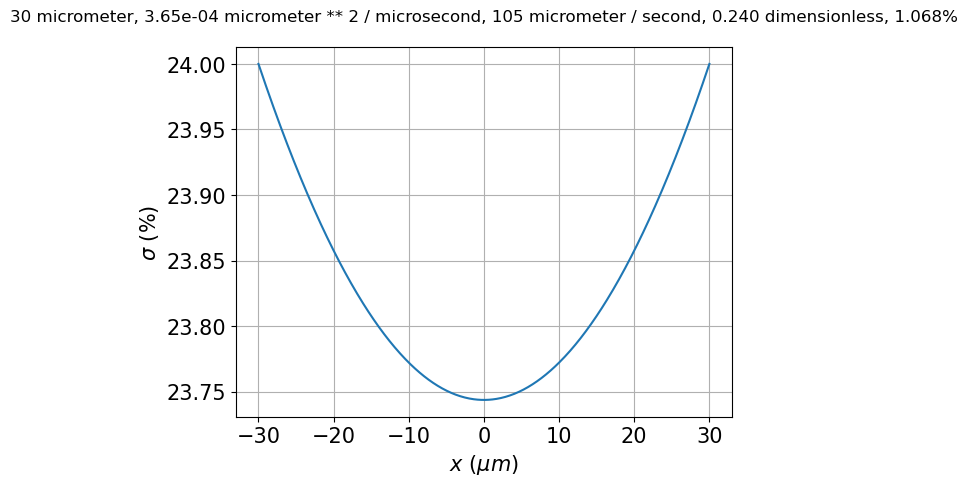

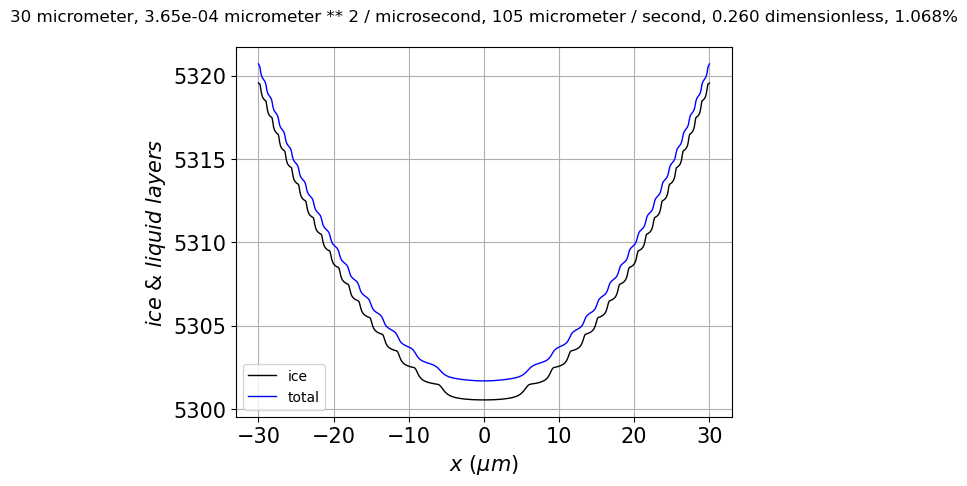

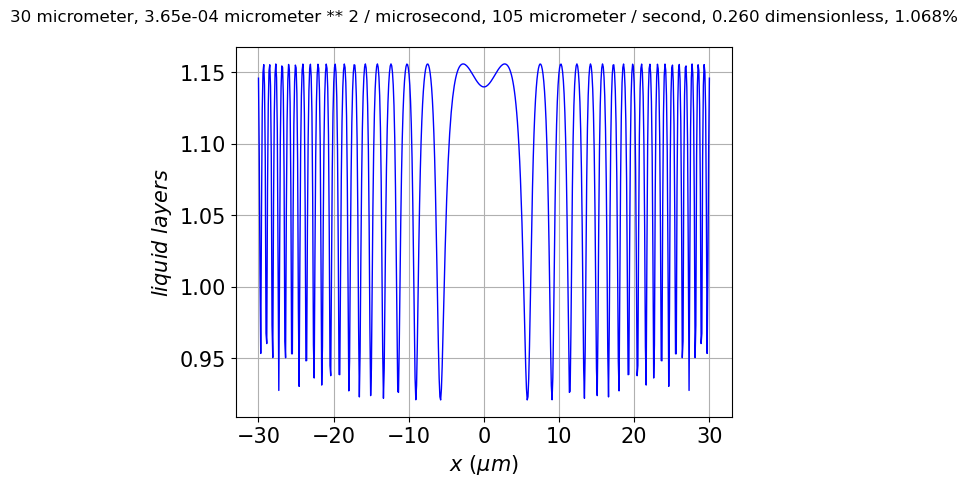

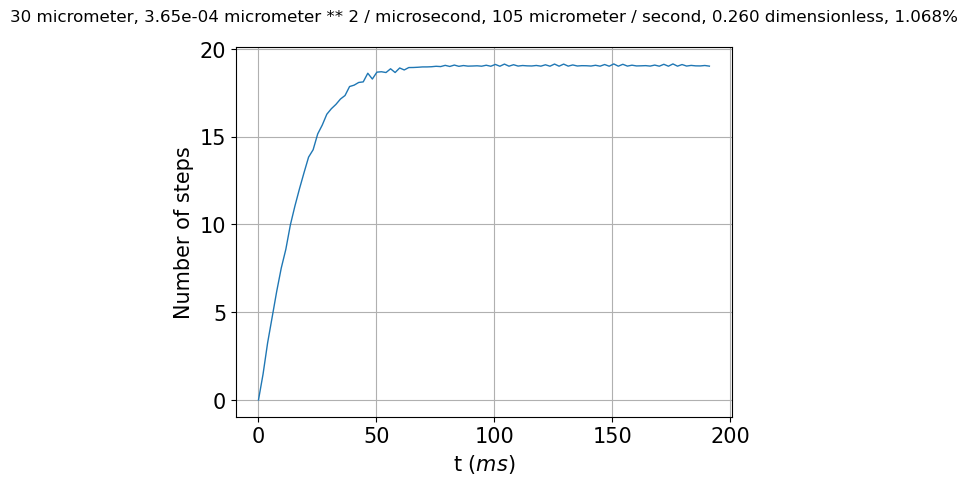

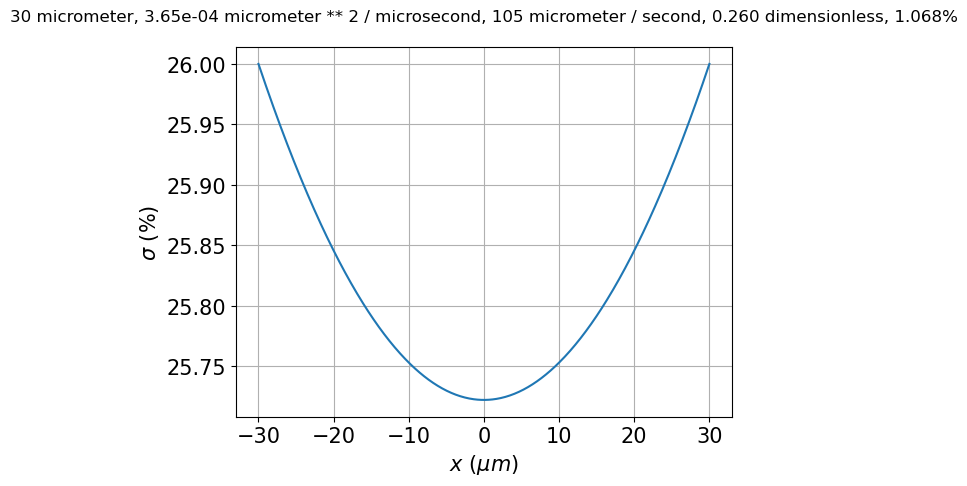

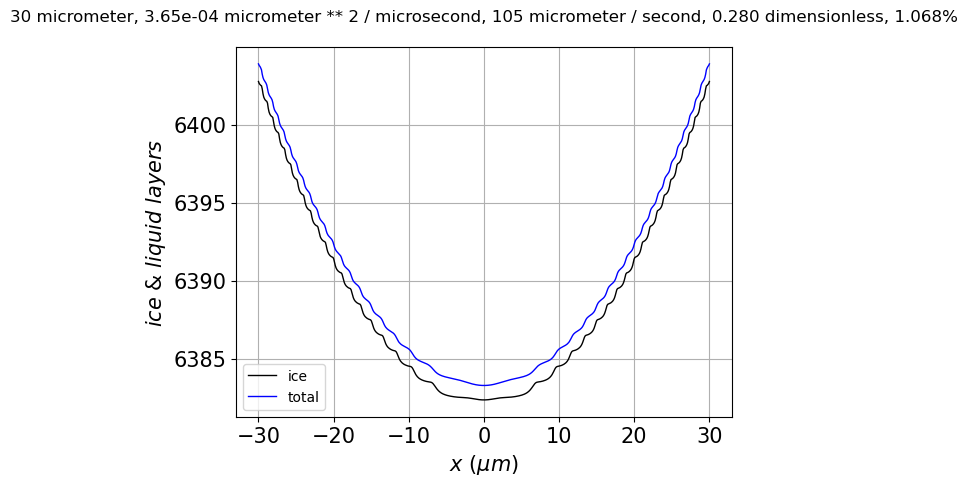

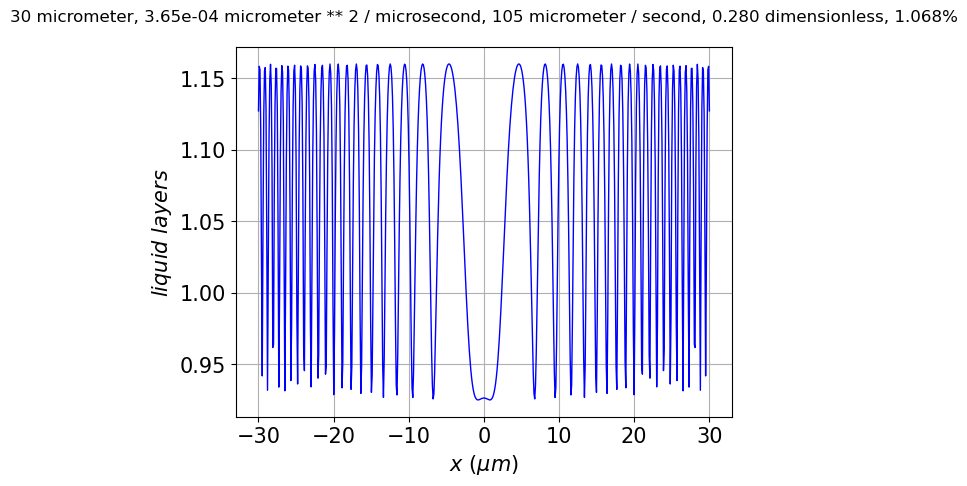

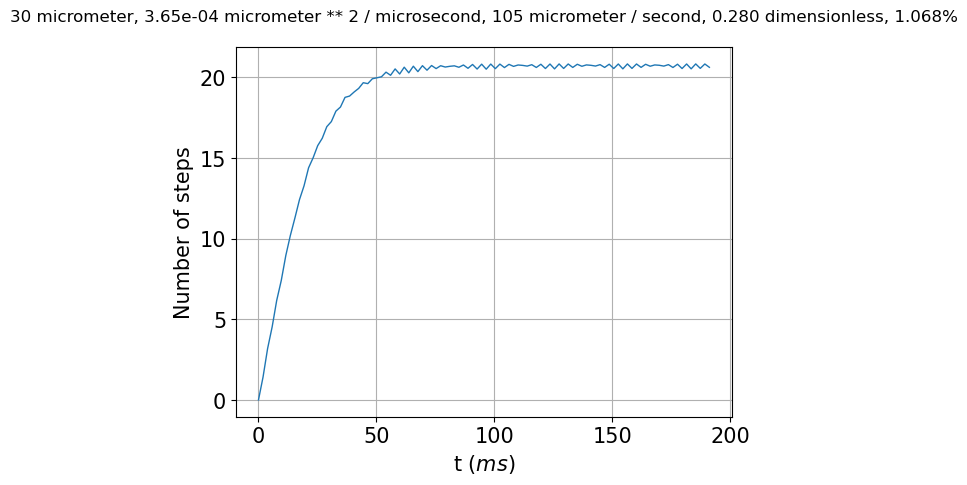

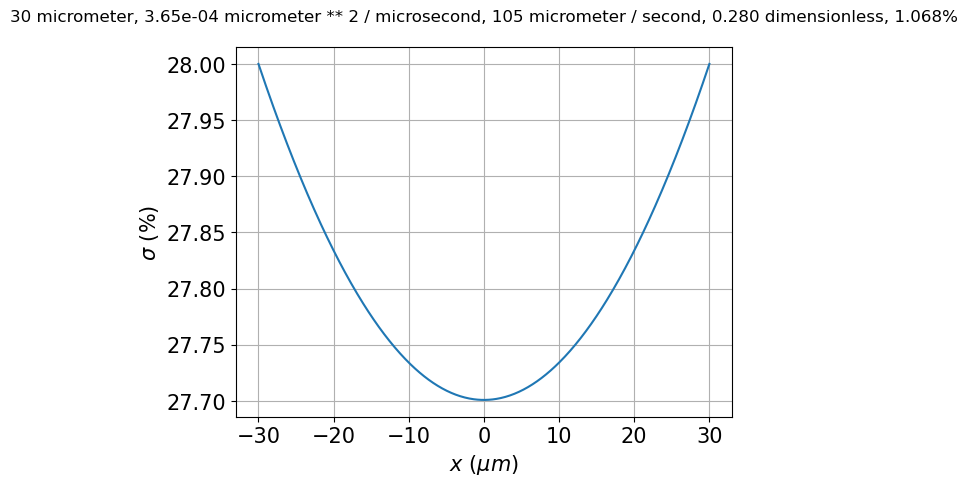

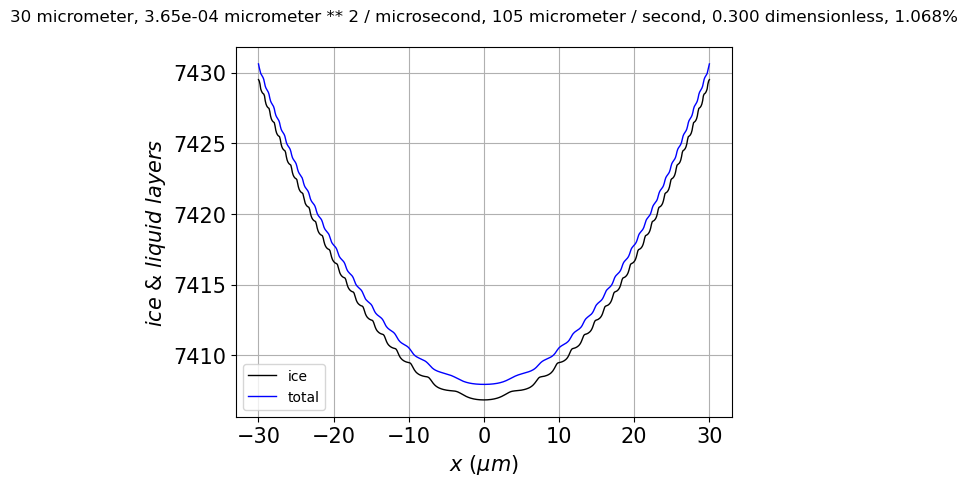

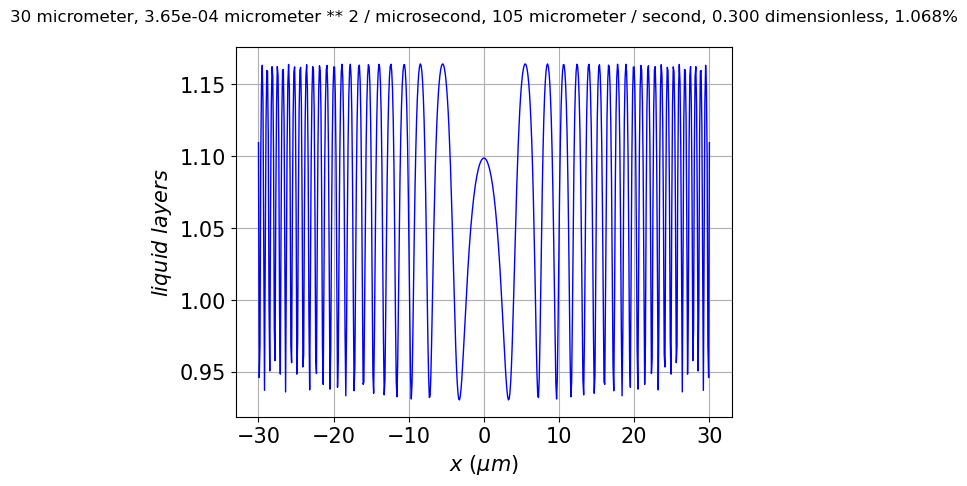

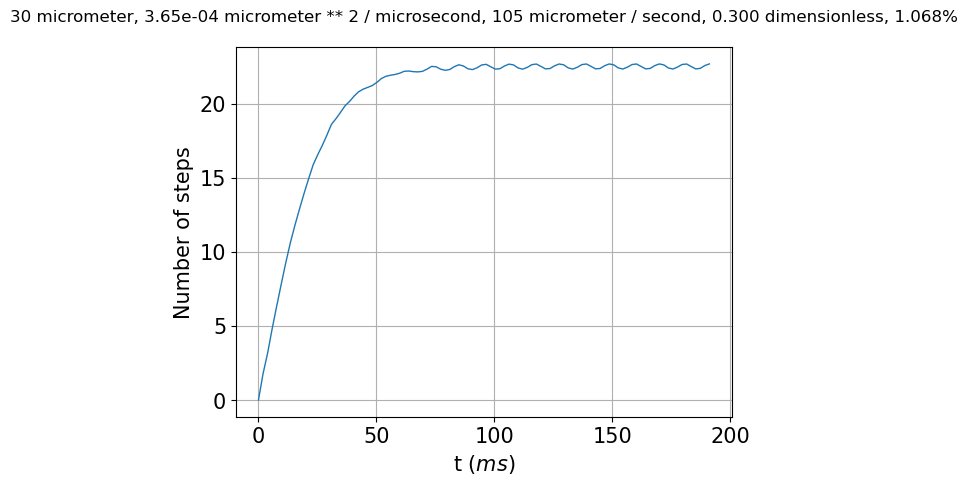

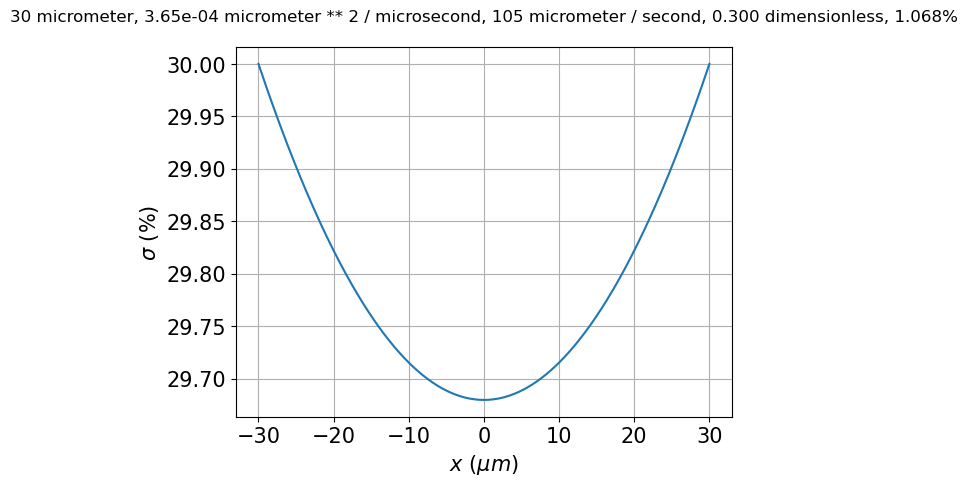

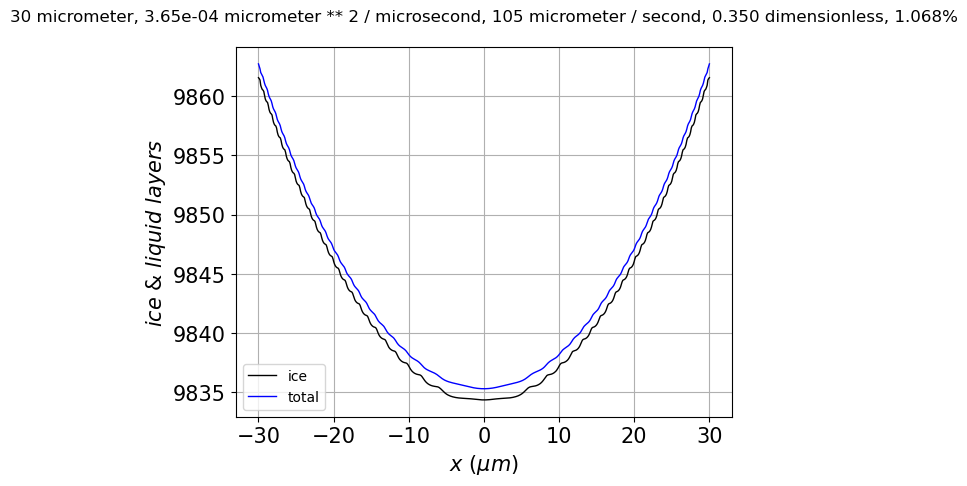

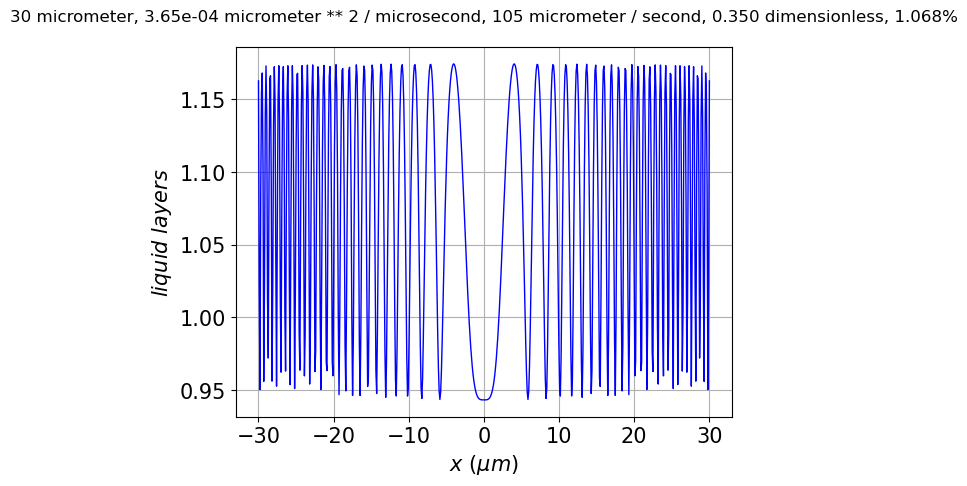

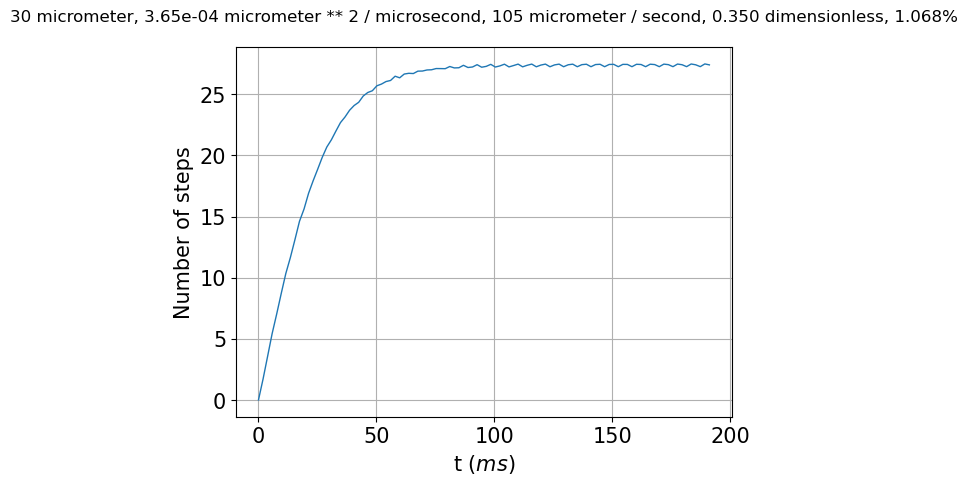

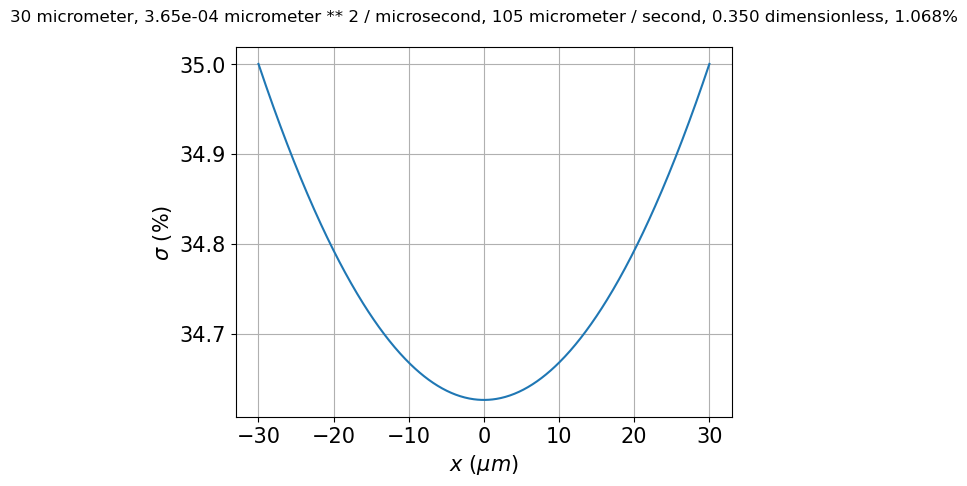

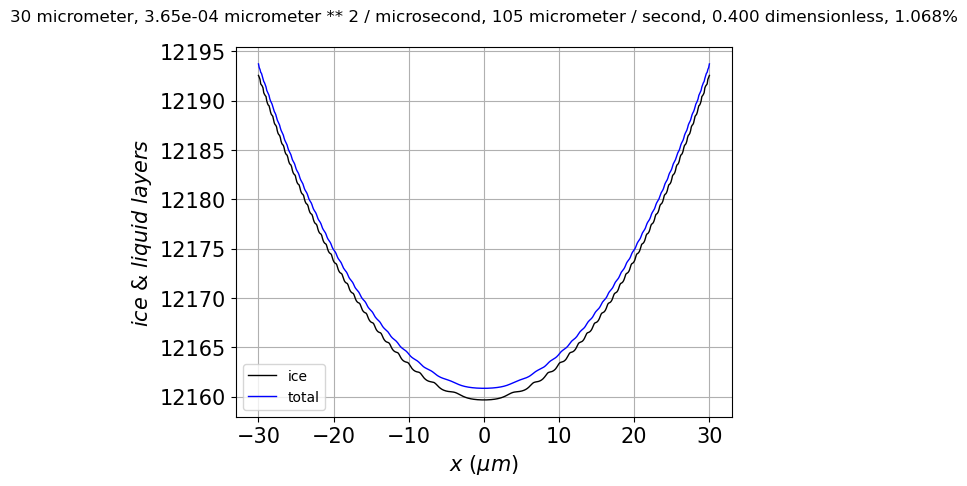

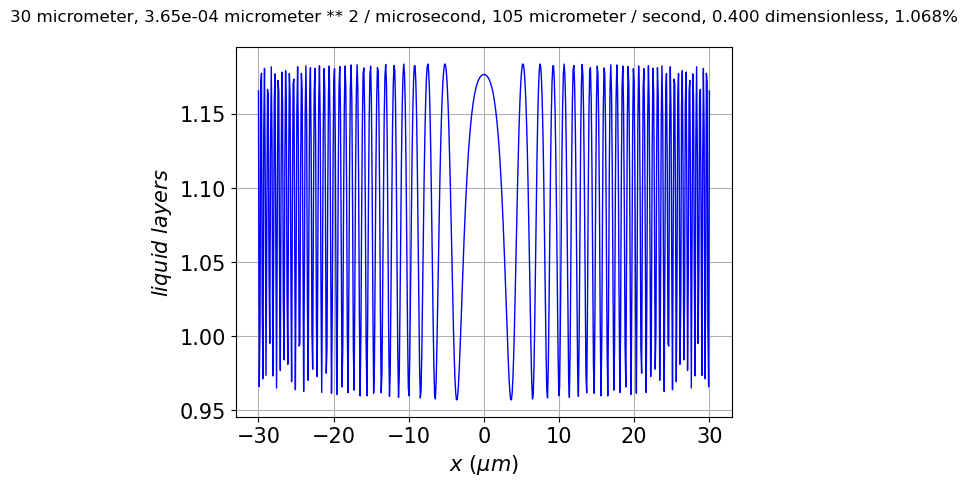

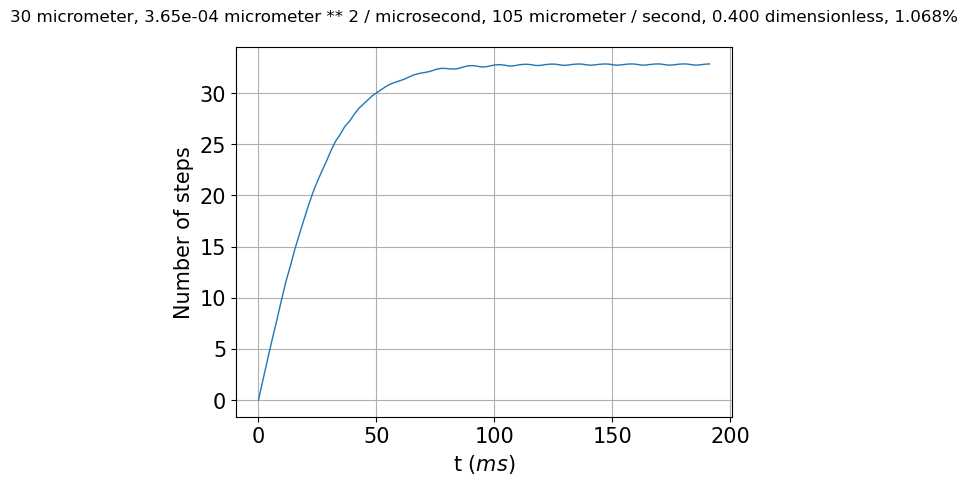

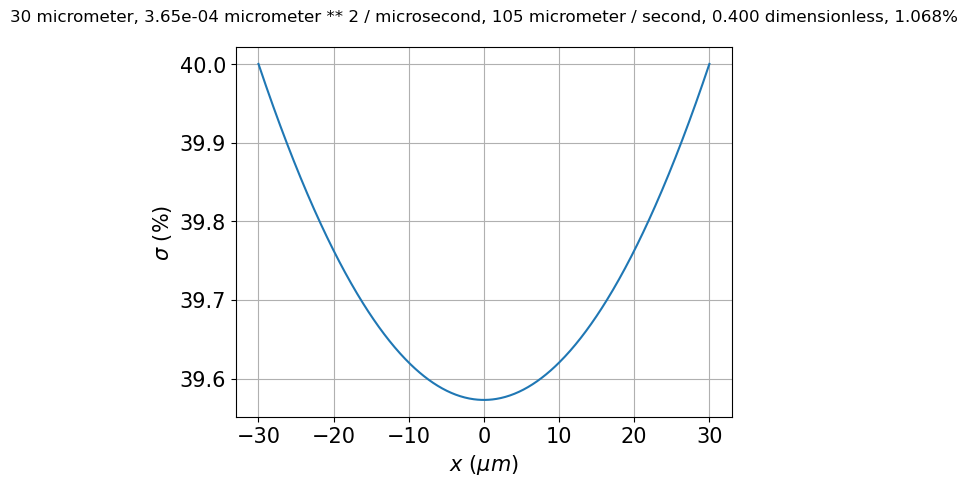

In [130]:
parameterlist = []
resultslist = []
for parameter_magnitudes in parameterlist_mag:

    # Size of the box
    L = AssignQuantity(parameter_magnitudes[0],'micrometer') 
    print('L =', L)

    # Surface diffusion coefficient
    D = AssignQuantity(parameter_magnitudes[1],'micrometer^2/microsecond') 
    print('D = ',D)

    # Kinetic velocity
    nu_kin = AssignQuantity(parameter_magnitudes[2],'micrometer / second')
    print('nu_kin = ',nu_kin)
    nu_kin_mlyperus = nu_kin/nmpermonolayer
    nu_kin_mlyperus.ito('1/microsecond')
    print('nu_kin_mlyperus =', nu_kin_mlyperus)

    # Supersaturation at the corner
    sigmaI_corner = AssignQuantity(parameter_magnitudes[3],'dimensionless')
    print('sigmaI_corner =', sigmaI_corner)
    
    # Supersaturation at the corner
    c_r_percent = AssignQuantity(parameter_magnitudes[4],'dimensionless')
    print('c_r_percent =', c_r_percent)
    c_r = c_r_percent/100
    
    # Number of points on the ice surface
    Lx_reference = AssignQuantity(75,'micrometer')
    nx_crystal = int(1501*L/Lx_reference)
    print('nx (crystal) =', nx_crystal)
    x_QLC = np.linspace(-L,L,nx_crystal)
    
    # supersaturation over the ice surface
    sigmaI_QLC = sigmaI_corner*(c_r*(x_QLC/L)**2+1-c_r)

    # Scaled version of the diffusion coefficient
    deltax = x_QLC[1]-x_QLC[0]
    print('Spacing of points on the ice surface =', deltax)
    Doverdeltax2 = D/deltax**2

    # Estimating/deciding on how long to make the integration
    print('Estimating times for the trajectory run')
    L_reference = AssignQuantity(1,'millimeter')
    time_reference = AssignQuantity(1,'millisecond')
    tlast_estimated = (L*L_reference/D*time_reference)**.5
    tlast_estimated.ito('millisecond'); print('   time (est) = ', tlast_estimated)
    tlast_msec = tlast_estimated; print('   time (used) = ',tlast_msec)
    tlast = tlast_msec.to('microsecond')
    if growing:
        tlast /= 1.5
    else:
        tlast *= 1.5

    # Number of time steps to report back
    ntimes = 100
    tkeep_1Darr = np.linspace(0,tlast,ntimes)
    print('   dt =', tkeep_1Darr[1]-tkeep_1Darr[0])

    # Initialize as a pre-equilibrated layer of liquid over ice
    Ntot_init_1D = np.ones(nx_crystal)
    NQLL_init_1D = QLC.getNQLL(Ntot_init_1D,Nstar,Nbar)

    # Solve the 1-D problem
    Ntotkeep_1D, NQLLkeep_1D = QLC.run_f1d(\
                    NQLL_init_1D, Ntot_init_1D, tkeep_1Darr,\
                    Nbar, Nstar, sigma0, nu_kin_mlyperus, Doverdeltax2, tau_eq, sigmaI_QLC,
                    AssignQuantity,\
                    verbose=0, odemethod='LSODA')
    Nicekeep_1D = Ntotkeep_1D-NQLLkeep_1D

    # Report
    title_params = \
        "{:.0f}".format(L.magnitude)+' '+str(L.units)+\
        ", "+np.format_float_scientific(D.magnitude,precision=2)+" "+str(D.units)+\
        ", "+"{:.0f}".format(nu_kin.magnitude)+' '+str(nu_kin.units)+\
        ", "+"{:.3f}".format(sigmaI_corner.magnitude)+' '+str(sigmaI_corner.units)+\
        ", "+"{:.3f}".format(c_r_percent.magnitude)+'%'+\
        "\n"
    g_ice_QLC = QLC.report_1d_growth_results(\
        x_QLC,tkeep_1Darr,NQLLkeep_1D,Ntotkeep_1D,Nicekeep_1D,nmpermonolayer, \
        graphics=True,title_params=title_params)
    print('c_r(%) =', c_r_percent)
    print('final g_ice_QLC =',g_ice_QLC)
    alpha = g_ice_QLC/(sigmaI_corner*nu_kin)
    alpha = AssignQuantity(alpha,'dimensionless')
    print('alpha relative to sigmaI_corner =',alpha)

    plt.figure()
    plt.plot(x_QLC,sigmaI_QLC*100)
    plt.grid(True)
    plt.xlabel('$x \ (\mu m)$',fontsize=fontsize)
    plt.ylabel('$\sigma \ (\%)$',fontsize=fontsize)
    rcParams['xtick.labelsize'] = ticklabelsize 
    rcParams['ytick.labelsize'] = ticklabelsize
    plt.title(title_params)

    lastfraction = 0.3
    itimes_almost_end = int(ntimes*(1-lastfraction))
    f = np.max(Ntotkeep_1D,axis=1) - np.min(Ntotkeep_1D,axis=1)
    nsteps_ss = np.mean(f[itimes_almost_end:-1])
    print('nsteps average of last', lastfraction*100, '% (', ntimes-itimes_almost_end, 'points) =', nsteps_ss)
    lambda_average = L/nsteps_ss
    print('estimated lambda =', lambda_average)
    results = [g_ice_QLC, lambda_average, alpha]
    resultslist.append(results)
    parameters = [L,D,nu_kin,sigmaI_corner,c_r_percent]
    parameterlist.append(parameters)
    print('Done with scenario ', len(resultslist),' out of ', len(parameterlist_mag))
    print('--------------------')

In [131]:
# Repackaging the parameters
L_list = np.empty(0)
D_list = np.empty(0)
nu_kin_list = np.empty(0)
sigmaI_corner_list = np.empty(0)
c_r_percent_list = np.empty(0)
for this_parameterset in parameterlist:
    L_list = np.append(L_list,this_parameterset[0])
    D_list = np.append(D_list,this_parameterset[1])
    nu_kin_list = np.append(nu_kin_list,this_parameterset[2])
    sigmaI_corner_list = np.append(sigmaI_corner_list,this_parameterset[3])
    c_r_percent_list = np.append(c_r_percent_list,this_parameterset[4])
c_r_list = c_r_percent_list/100
print('parameters')
print(L_list)
print(D_list)
print(nu_kin_list)
print(sigmaI_corner_list)
print(c_r_percent_list)

zp_list = (D_list/c_r_list/nu_kin_list)**.5
zp_list.ito('micrometer^.5')


# Repackaging the results
g_ice_QLC_list = np.empty(0)
lambda_average_list = np.empty(0)
alpha_list = np.empty(0)
for this_resultset in resultslist:
    g_ice_QLC_list = np.append(g_ice_QLC_list,this_resultset[0])
    lambda_average_list = np.append(lambda_average_list,this_resultset[1])
    alpha_list = np.append(alpha_list,this_resultset[2])
print('\n results \n')
print(g_ice_QLC_list,'\n')
print(lambda_average_list,'\n')
print(alpha_list,'\n')
print(zp_list,'\n')

parameters
[30.0 30.0 30.0 30.0 30.0 30.0 30.0 30.0 30.0] micrometer
[0.000365 0.000365 0.000365 0.000365 0.000365 0.000365 0.000365 0.000365 0.000365] micrometer ** 2 / microsecond
[105.0 105.0 105.0 105.0 105.0 105.0 105.0 105.0 105.0] micrometer / second
[0.244 0.22 0.23 0.24 0.26 0.28 0.3 0.35 0.4] dimensionless
[1.068 1.068 1.068 1.068 1.068 1.068 1.068 1.068 1.068] dimensionless

 results 

[8.886086713724287 5.503433362895489 7.035715597027672 8.381937176907691 10.789119182249078 12.988168634732078 15.076131926031179 20.0161848385579 24.748896856500714] micrometer / second 

[1.6751800683618399 1.7553691161849856 1.7476231486107572 1.6988078523275942 1.5744096088166135 1.4482877835485979 1.3331705305594244 1.0954035950339611 0.9144159838199145] micrometer 

[0.3468417921047731 0.23824386852361423 0.2913339791729885 0.3326165546391941 0.39520583085161454 0.4417744433582339 0.47860736273114857 0.544658090845113 0.5892594489643027] dimensionless 

[18.041230546814234 18.04123054681

Exploring sigmaI_corner, growth ...

best-fit parameters = 
lambda_g0, x_g0=(1.7472216209287446, 6.898153517754367), x_g0=6.898153517754367


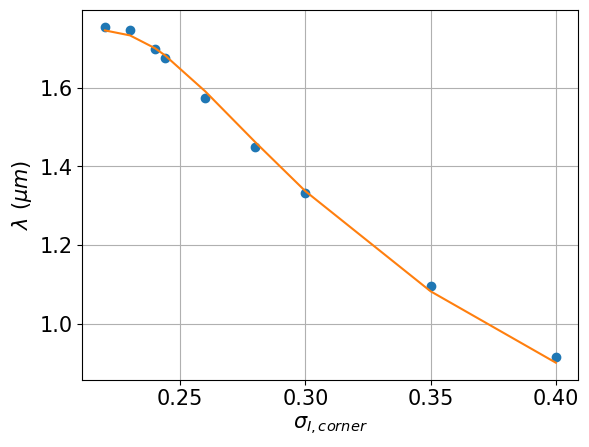

In [132]:
# Getting lambda as a function of the z-parameter
if not exploring_sigmaI_corner:
    print('Exploring lambda(z) ...')
    rindex = 1
    izsort = np.argsort(zp_list.magnitude)
    x = zp_list[izsort]
    y = lambda_average_list[izsort]
    plt.plot(x,y,'o')
    plt.plot(zp_list[0],lambda_average_list[0],'ks',markersize=15)
    plt.xlabel('z ($\mu m ^{1/2}$)',fontsize=fontsize)
    plt.ylabel('$\lambda \ (\mu m)$',fontsize=fontsize)
    rcParams['xtick.labelsize'] = ticklabelsize 
    rcParams['ytick.labelsize'] = ticklabelsize
    if len(x)>2:
        p = plt.polyfit(x.magnitude,y.magnitude,1)
        plt.plot(x,plt.polyval(p,x.magnitude))
        print('\nbest-fit y-intercept and slope = ')
        print(np.flip(p))
    plt.grid(True)
    print()
    print('zp_list[0] =',zp_list[0])
    print('lambda[0] =',lambda_average_list[0])

    print()
    print('z (sorted) =',x)
    print()
    print('lambda (sorted) =',y)
    
# Getting lambda as a function of sigma_corner
elif exploring_sigmaI_corner and growing:
    print('Exploring sigmaI_corner, growth ...')
    xp = sigmaI_corner_list
    yp = lambda_average_list
    ixsort = np.argsort(xp.magnitude)
    x = xp[ixsort]
    y = yp[ixsort]
    plt.plot(x,y,'o')
    plt.xlabel('$\sigma_{I,corner}$',fontsize=fontsize)
    plt.ylabel('$\lambda \ (\mu m)$',fontsize=fontsize)
    rcParams['xtick.labelsize'] = ticklabelsize 
    rcParams['ytick.labelsize'] = ticklabelsize
    plt.grid(True)
    if len(x)>2: 
        
        # Define the function to fit
        def lambda_growth_func(x, lambda_g0, x_g0):
            arg = 1/((x-sigma0)*x_g0)
            y = lambda_g0*(1-np.exp(-arg))
            return y
        
        # Do the fit and graph it
        lambda_g0, x_g0 = optimize.curve_fit(lambda_growth_func,xdata=x.magnitude,ydata=y.magnitude)[0]
        plt.plot(x,lambda_growth_func(x, lambda_g0, x_g0))
        print('\nbest-fit parameters = ')
        print(f'lambda_g0, x_g0={lambda_g0, x_g0}, x_g0={x_g0}')
        
        # This keeps the data for plotting later
        x_exploring_sigmaI_corner_growth = x
        y_exploring_sigmaI_corner_growth = y
        
    
# Getting lambda as a function of sigma_corner
elif exploring_sigmaI_corner and ablating:
    print('Exploring sigmaI_corner, ablating ...')
    xp = sigmaI_corner_list
    yp = lambda_average_list
    ixsort = np.argsort(xp.magnitude)
    x = xp[ixsort]
    y = yp[ixsort]
    plt.plot(x,y,'o')
    plt.xlabel('$\sigma_{I,corner}$',fontsize=fontsize)
    plt.ylabel('$\lambda \ (\mu m)$',fontsize=fontsize)
    rcParams['xtick.labelsize'] = ticklabelsize 
    rcParams['ytick.labelsize'] = ticklabelsize
    plt.grid(True)
    if len(x)>2: 
        
        # Define the function to fit
        def lambda_ablation_func(x, lambda_a0,x_a0):
            y = lambda_a0/(-x)**x_a0 # This is a power function
            return y
        lambda_a0, x_a0 = optimize.curve_fit(lambda_ablation_func,xdata=x.magnitude,ydata=y.magnitude)[0]
#         def lambda_ablation_func(x, lambda_a0,x_a0):
#             arg = 1/(x*x_a0); y = lambda_a0*(1-np.exp(arg)) # This is an exponential function
#             return y
#         lambda_a0, x_a0 = optimize.curve_fit(lambda_ablation_func,xdata=x.magnitude,ydata=y.magnitude)[0]

        plt.plot(x,lambda_ablation_func(x, lambda_a0,x_a0))
        print('\nbest-fit parameters = ')
        print(f'lambda_a0,x_a0={lambda_a0,x_a0}')
        
        # This keeps the data for plotting later
        x_exploring_sigmaI_corner_ablation = x
        y_exploring_sigmaI_corner_ablation = y
        
    


### Graphics combining growing and ablating supersaturation


best-fit parameters = 
lambda_g0, x_g0=(1.7472216209287446, 6.898153517754367)
lambda_a0, x_a0=(0.4410285288568325, 0.4223586468922132)


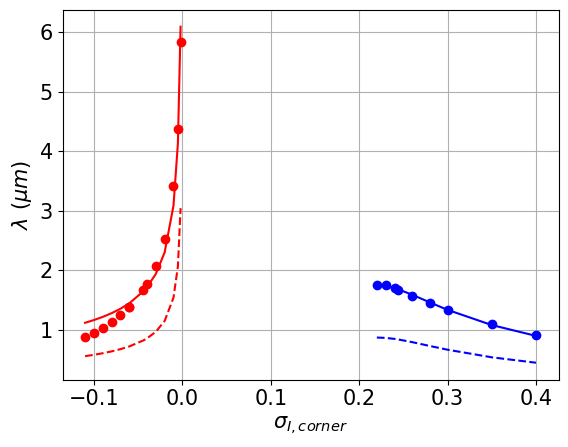

In [133]:
Iwantfig8 = True
if Iwantfig8:

    plt.plot(x_exploring_sigmaI_corner_growth,y_exploring_sigmaI_corner_growth,'bo')
    plt.plot(x_exploring_sigmaI_corner_growth,lambda_growth_func(x_exploring_sigmaI_corner_growth, lambda_g0, x_g0),'b')
    plt.plot(x_exploring_sigmaI_corner_growth,lambda_growth_func(x_exploring_sigmaI_corner_growth, lambda_g0, x_g0)/2,'b--')
    plt.plot(x_exploring_sigmaI_corner_ablation,y_exploring_sigmaI_corner_ablation,'ro')
    plt.plot(x_exploring_sigmaI_corner_ablation,lambda_ablation_func(x_exploring_sigmaI_corner_ablation, lambda_a0, x_a0),'r')
    plt.plot(x_exploring_sigmaI_corner_ablation,lambda_ablation_func(x_exploring_sigmaI_corner_ablation, lambda_a0, x_a0)/2,'r--')

    
    plt.xlabel('$\sigma_{I,corner}$',fontsize=fontsize)
    plt.ylabel('$\lambda \ (\mu m)$',fontsize=fontsize)
    rcParams['xtick.labelsize'] = ticklabelsize 
    rcParams['ytick.labelsize'] = ticklabelsize
    plt.grid(True)
    print('\nbest-fit parameters = ')
    print(f'lambda_g0, x_g0={lambda_g0,x_g0}')
    print(f'lambda_a0, x_a0={lambda_a0,x_a0}')

### Graphing results as a function of parameters

In [134]:
# # This does some plotting as a function of L
# plt.figure()
# pindex = 0
# rindex = 1
# xp = Strategy_A_parameterlist_mag[:,pindex]
# yp = Strategy_A_resultslist_mag[:,rindex]
# ixsort = np.argsort(xp)
# x = xp[ixsort]
# y = yp[ixsort]
# plt.plot(x,y,'o')
# plt.xlabel(parameter_names[pindex],fontsize=fontsize)
# plt.ylabel(result_names[rindex],fontsize=fontsize)
# rcParams['xtick.labelsize'] = ticklabelsize 
# rcParams['ytick.labelsize'] = ticklabelsize
# # p = plt.polyfit(x,y,2)
# # p[2]=0
# # plt.plot(x,plt.polyval(p,x))
# # print(np.flip(p))
# plt.grid(True)

In [135]:
# # This does some plotting as a function of c_r
# plt.figure()
# pindex = 4
# rindex = 1
# xp = Strategy_A_parameterlist_mag[:,pindex]
# yp = Strategy_A_resultslist_mag[:,rindex]
# ixsort = np.argsort(xp)
# x = xp[ixsort]
# y = yp[ixsort]
# plt.plot(x,y,'o')
# plt.xlabel(parameter_names[pindex],fontsize=fontsize)
# plt.ylabel(result_names[rindex],fontsize=fontsize)
# rcParams['xtick.labelsize'] = ticklabelsize 
# rcParams['ytick.labelsize'] = ticklabelsize
# # p = plt.polyfit(x,y,2)
# # p[2]=0
# # plt.plot(x,plt.polyval(p,x))
# # print(np.flip(p))
# plt.grid(True)

In [136]:
# x_g0 = 6.679894940742424